### plot_sky_brightness_model

Visualizing the machine-learned (PTF) sky brightness model

In [1]:
# hack to get the path right
import sys
sys.path.append('..')

In [3]:
from ztf_sim.sky_brightness import SkyBrightness
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
sns.set_style('ticks')
sns.set_context('talk')

In [4]:
# load the training data
df = pd.read_csv('../data/ptf-iptf_diq.csv.gz')

In [5]:
df.head()

,Unnamed: 0,pid,mjd,sky_brightness,fwhmsex,airmass,moonphas,moonillf,moonalt,azimuth,altitude,limiting_mag,moon_dist,filterkey,sunalt
0,0,9526066.0,55855.35663,20.9546,2.55,1.28813,255.138,-0.371756,3.82645,282.3300,50.8821,21.4367,121.233998,1,-63.249279
1,1,9526067.0,55855.11654,20.4636,2.85,2.42588,258.154,-0.397358,-43.28850,79.3789,24.2281,20.9579,95.767669,1,-21.509225
2,2,9526068.0,55855.37666,20.7441,2.45,1.26798,254.885,-0.369625,9.51225,144.7150,52.0187,21.3802,66.048980,1,-59.257531
3,3,9526069.0,55855.17671,21.0459,2.65,1.35159,257.401,-0.390933,-38.17270,145.8370,47.6722,21.4349,132.815569,1,-39.405352
4,4,9526070.0,55855.11294,21.0488,2.45,1.36807,258.199,-0.397743,-43.34780,117.8580,46.9173,21.5206,134.900090,1,-20.426107


Let's look at the range of the data:

In [6]:
for col in df.columns:
    print '{}: {}-{}'.format(col, df[col].min(), df[col].max())

Unnamed: 0: 0-1854348
pid: 9526066.0-30929549.0
mjd: 54891.11868-57806.37396
sky_brightness: 13.0019-24.9965
fwhmsex: 0.0-80.05
airmass: 1.0-13.2512
moonphas: 0.000607-360.0
moonillf: -1.0-1.0
moonalt: -82.7048-82.1672
azimuth: 0.0-359.996
altitude: 0.0-89.9013
limiting_mag: 13.4326-27.1295
moon_dist: 1.78679653575-179.826635825
filterkey: 1-4
sunalt: -80.0779224535--10.4975803864


So there are clearly outliers.  Let's look at histograms to find good fiducial values:

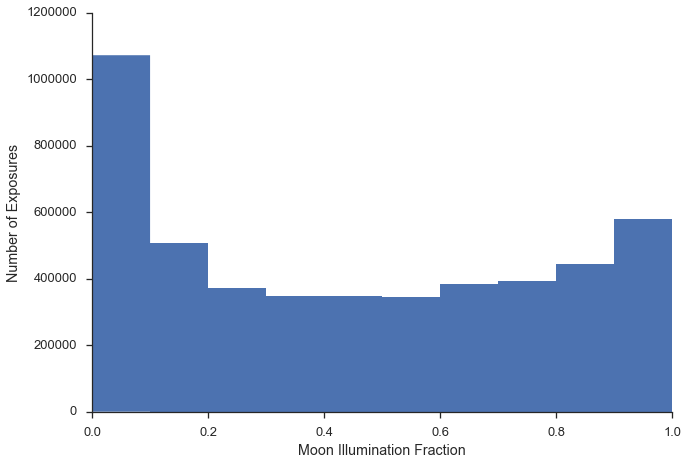

In [7]:
plt.hist(np.abs(df.moonillf))
plt.xlabel('Moon Illumination Fraction')
plt.ylabel('Number of Exposures')
sns.despine()

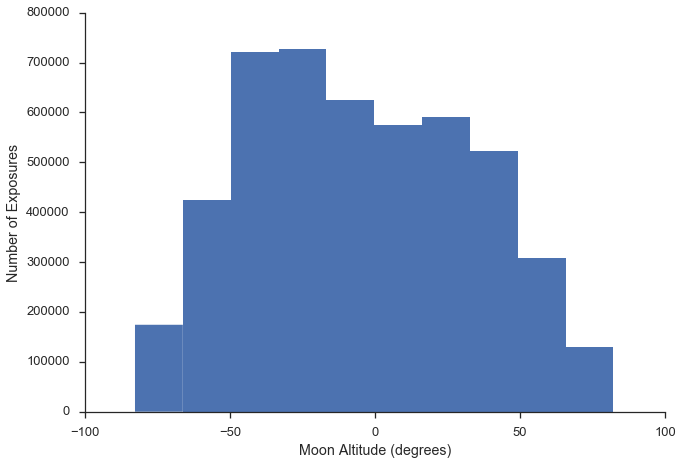

In [8]:
plt.hist(df.moonalt)
plt.xlabel('Moon Altitude (degrees)')
plt.ylabel('Number of Exposures')
sns.despine()

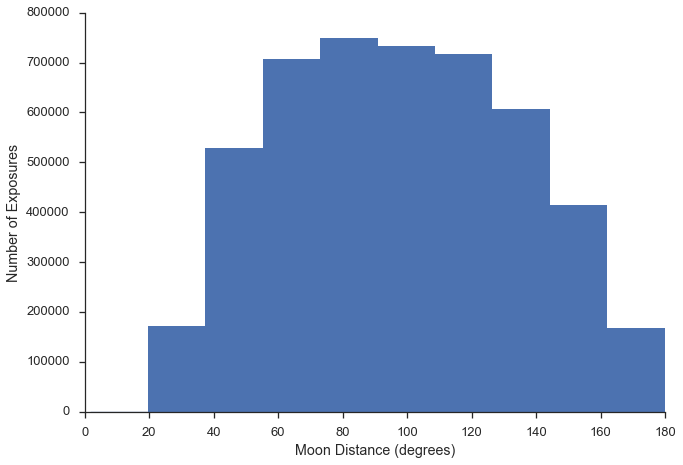

In [9]:
plt.hist(df.moon_dist)
plt.xlabel('Moon Distance (degrees)')
plt.ylabel('Number of Exposures')
sns.despine()

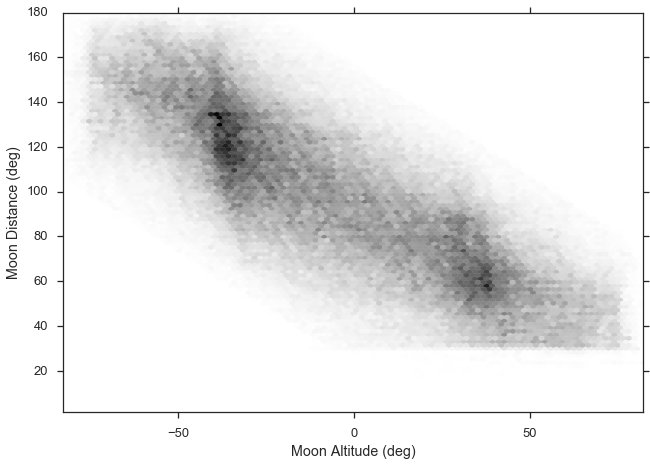

In [10]:
plt.hexbin(df['moonalt'],df['moon_dist'])
plt.xlabel('Moon Altitude (deg)')
plt.ylabel('Moon Distance (deg)')

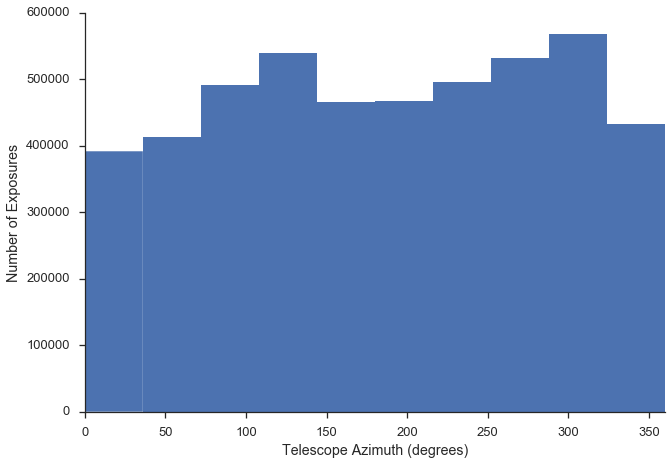

In [11]:
plt.hist(df.azimuth)
plt.xlabel('Telescope Azimuth (degrees)')
plt.ylabel('Number of Exposures')
plt.xlim(0,360)
sns.despine()

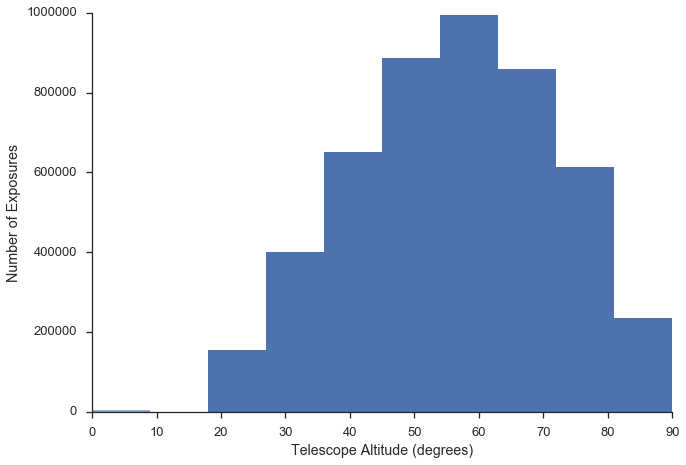

In [12]:
plt.hist(df.altitude)
plt.xlabel('Telescope Altitude (degrees)')
plt.ylabel('Number of Exposures')
plt.xlim(0,90)
sns.despine()

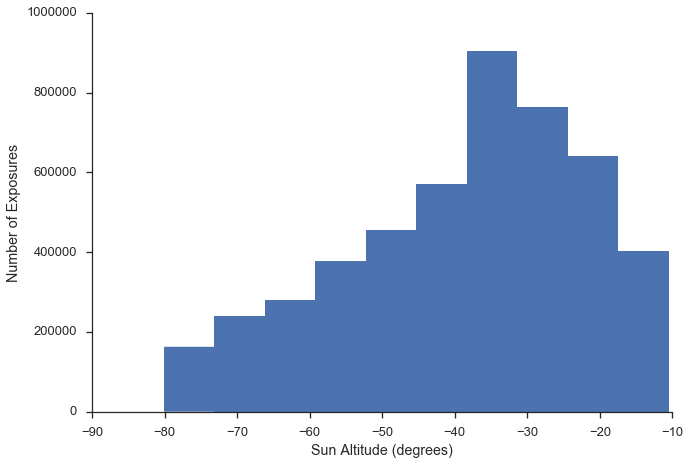

In [13]:
plt.hist(df.sunalt)
plt.xlabel('Sun Altitude (degrees)')
plt.ylabel('Number of Exposures')
plt.xlim(-90,-10)
sns.despine()

21.0915


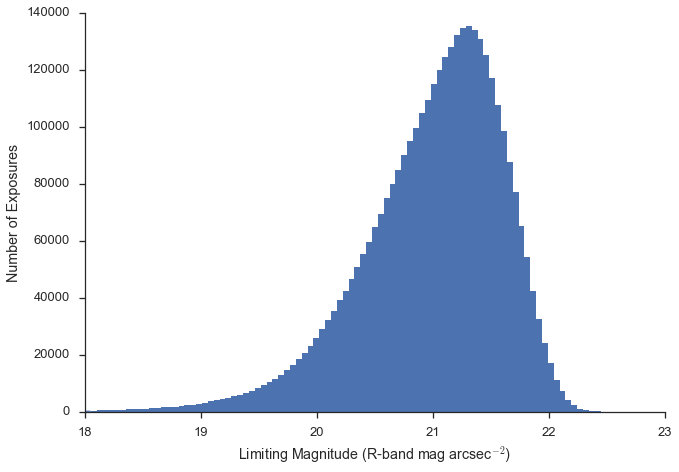

In [14]:
#w = (df['filterkey'] == 2)
w = (df['filterkey'] == 2) & (df['moonillf'] < 10.)
print(df[w]['limiting_mag'].median())
plt.hist(df[w]['limiting_mag'],bins=np.linspace(18,23,100))
plt.xlabel('Limiting Magnitude (R-band mag arcsec$^{-2}$)')
plt.ylabel('Number of Exposures')
sns.despine()

21.3963


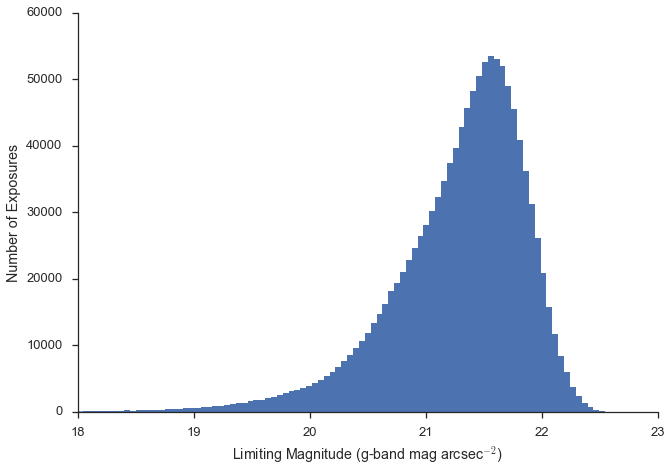

In [15]:
#w = (df['filterkey'] == 1)
w = (df['filterkey'] == 1) & (df['moonillf'] < 10.)
print(df[w]['limiting_mag'].median())
plt.hist(df[w]['limiting_mag'],bins=np.linspace(18,23,100))
plt.xlabel('Limiting Magnitude (g-band mag arcsec$^{-2}$)')
plt.ylabel('Number of Exposures')
sns.despine()

20.5761


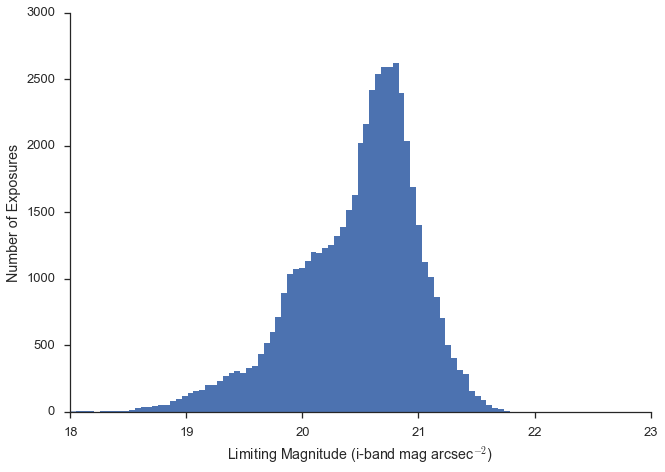

In [16]:
#w = (df['filterkey'] == 4)
w = (df['filterkey'] == 4) & (df['moonillf'] < 10.)
print(df[w]['limiting_mag'].median())
plt.hist(df[w]['limiting_mag'],bins=np.linspace(18,23,100))
plt.xlabel('Limiting Magnitude (i-band mag arcsec$^{-2}$)')
plt.ylabel('Number of Exposures')
sns.despine()

Let's look at the dependence of FWHM on altitude:

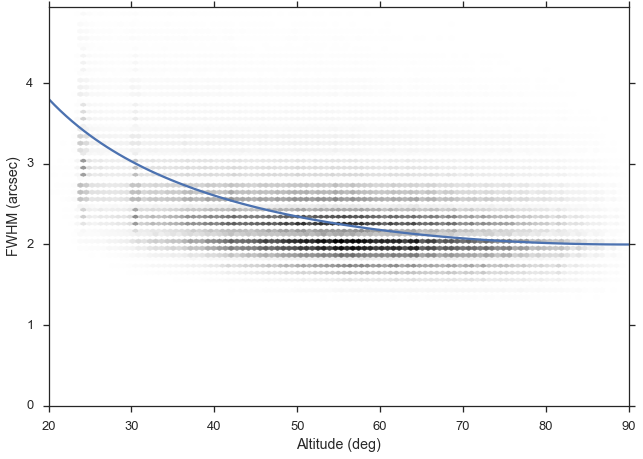

In [17]:
w = (df['filterkey'] == 2)
w &= (df['altitude'] > 20) & (df['fwhmsex'] < 5)
plt.hexbin(df[w]['altitude'],df[w]['fwhmsex'])
plt.xlabel('Altitude (deg)')
plt.ylabel('FWHM (arcsec)')
alts = np.linspace(20,90,100)
airmasses = 1./np.cos(np.radians(90.-alts))
plt.plot(alts,2*airmasses**(3./5))

g-band

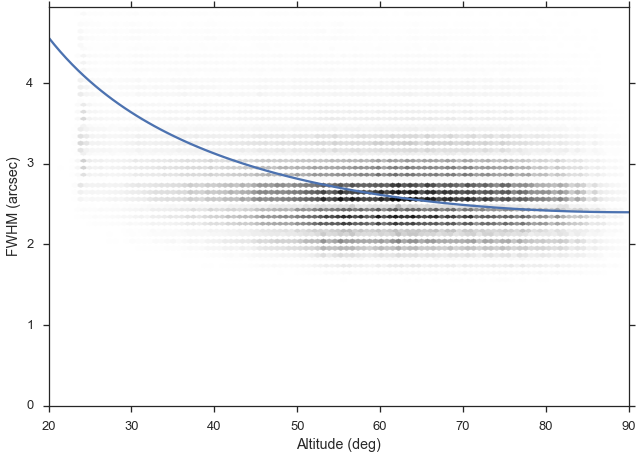

In [18]:
w = (df['filterkey'] == 1)
w &= (df['altitude'] > 20) & (df['fwhmsex'] < 5)
plt.hexbin(df[w]['altitude'],df[w]['fwhmsex'])
plt.xlabel('Altitude (deg)')
plt.ylabel('FWHM (arcsec)')
plt.plot(alts,2.4*airmasses**(3./5))

In [5]:
# load our model
Sky = SkyBrightness()

In [6]:
def test_conditions(moonillf=0,moonalt=40,moon_dist=60.,azimuth=120,altitude=60.,sunalt=-35,filter_id=2):
    """define convenience function for building inputs to SkyBrightness.
    
    Inputs should be scalars expect for one and only one vector.
    
    Note that manual inputs can yield unphysical moonalt/moon_dist pairs, but the real simulator will 
    calculate these correctly."""
    
    moonillf = np.atleast_1d(moonillf)
    moonalt = np.atleast_1d(moonalt)
    moon_dist = np.atleast_1d(moon_dist)
    azimuth = np.atleast_1d(azimuth)
    altitude = np.atleast_1d(altitude)
    sunalt = np.atleast_1d(sunalt)
    filter_id = np.atleast_1d(filter_id)
    
    maxlen = np.max([len(moonillf), len(moonalt), len(moon_dist), len(azimuth), len(altitude), len(sunalt),
                     len(filter_id)])
    
    def blow_up_array(arr,maxlen=maxlen):
        if (len(arr) == maxlen):
            return arr
        elif (len(arr) == 1):
            return np.ones(maxlen)*arr[0]
        else:
            raise ValueError
    
    moonillf = blow_up_array(moonillf)
    moonalt = blow_up_array(moonalt)
    moon_dist = blow_up_array(moon_dist)
    azimuth = blow_up_array(azimuth)
    altitude = blow_up_array(altitude)
    sunalt = blow_up_array(sunalt)
    filter_id = blow_up_array(filter_id)
    
    pars = {'moonillf':moonillf, 'moonalt':moonalt, 'moon_dist':moon_dist, 'azimuth':azimuth, 'altitude':altitude, 
           'sunalt':sunalt,'filter_id':filter_id}
    
    return pd.DataFrame(pars,index=np.arange(maxlen))

In [7]:
def select_data(df, moonillf=0,moonalt=40,moon_dist=60.,azimuth=120,altitude=60,sunalt=-35,filter_id=2):
    """return a boolean selecting data around fiducial inputs
    
    set parameter to None to skip comparison"""
    
    # start with boolean True array
    w = df['azimuth'] == df['azimuth']
    
    def anding(df,par,value,frac=0.2):
        if value is None:
            return True
        else:
            lima = value*(1-frac)
            limb = value*(1+frac)
            llim = np.atleast_1d(np.where(lima < limb, lima, limb))[0]
            ulim = np.atleast_1d(np.where(lima > limb, lima, limb))[0]
            # figure out which is smaller
            
            return (df[par] >= llim) & (df[par] <= ulim)
    
    w &= anding(df, 'moonillf', moonillf)
    w &= anding(df, 'moonalt', moonalt)
    w &= anding(df, 'moon_dist', moon_dist)
    w &= anding(df, 'azimuth', azimuth)
    w &= anding(df, 'altitude', altitude)
    w &= anding(df, 'sunalt', sunalt)
    
    # dataframe uses filterkey
    w &= (df['filterkey'] == filter_id)
    
    return w

In [22]:
# show that it works!
test_conditions(altitude=np.linspace(0,90,5))

,altitude,azimuth,filter_id,moon_dist,moonalt,moonillf,sunalt
0,0.0,120.0,2.0,60.0,40.0,0.0,-35.0
1,22.5,120.0,2.0,60.0,40.0,0.0,-35.0
2,45.0,120.0,2.0,60.0,40.0,0.0,-35.0
3,67.5,120.0,2.0,60.0,40.0,0.0,-35.0
4,90.0,120.0,2.0,60.0,40.0,0.0,-35.0


Now let's walk through the various parameters and look at the model behavior.

Vary moon illilumination fraction at 45 degree altitude, R-band:

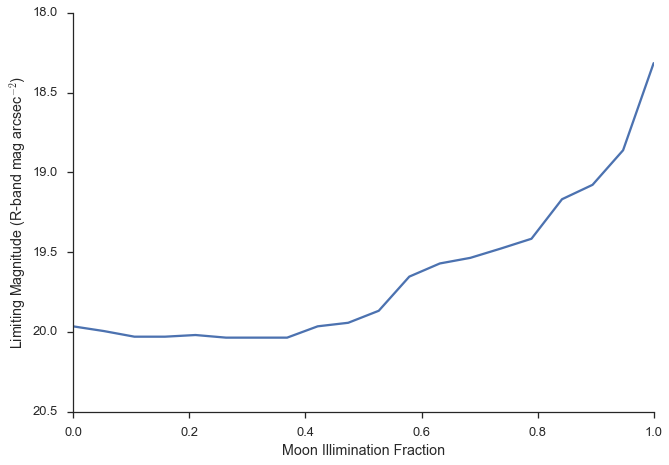

In [23]:
moonillfs = np.linspace(0,1,20)
dft = test_conditions(moonillf=moonillfs)
skies = Sky.predict(dft)
plt.plot(moonillfs,skies)
plt.gca().invert_yaxis()
plt.xlabel('Moon Illimination Fraction')
plt.ylabel('Limiting Magnitude (R-band mag arcsec$^{-2}$)')
sns.despine()

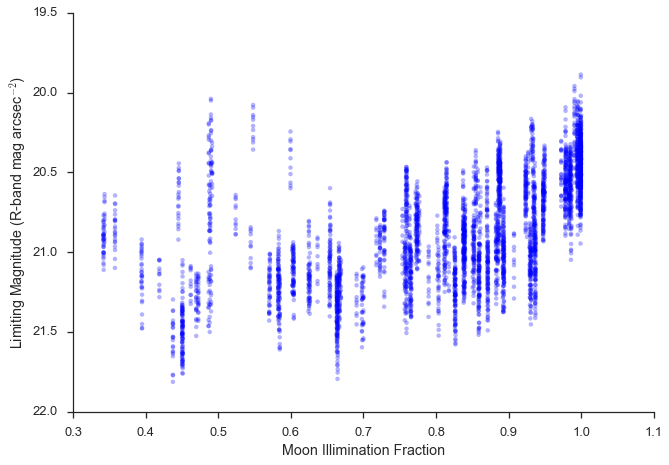

In [24]:
w =  select_data(df,moonillf=None)#,moonalt=45, moon_dist=45)
plt.scatter(np.abs(df[w]['moonillf']),df[w]['limiting_mag'],alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel('Moon Illimination Fraction')
plt.ylabel('Limiting Magnitude (R-band mag arcsec$^{-2}$)')
sns.despine()

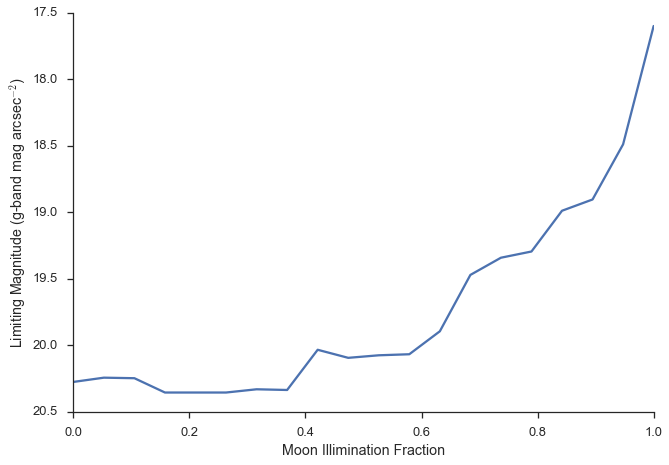

In [25]:
moonillfs = np.linspace(0,1,20)
dft = test_conditions(moonillf=moonillfs,filter_id=1)
skies = Sky.predict(dft)
plt.plot(moonillfs,skies)
plt.gca().invert_yaxis()
plt.xlabel('Moon Illimination Fraction')
plt.ylabel('Limiting Magnitude (g-band mag arcsec$^{-2}$)')
sns.despine()

Not as smooth as we might expect.  Let's look at the input data:

These data are surprisingly sparse!

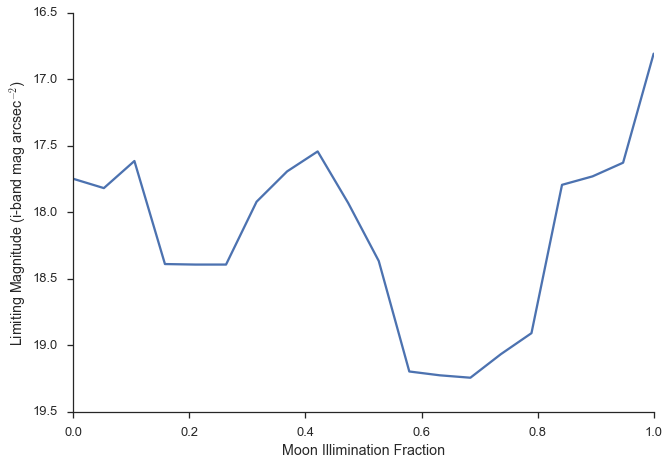

In [8]:
moonillfs = np.linspace(0,1,20)
dft = test_conditions(moonillf=moonillfs,filter_id=3)
skies = Sky.predict(dft)
plt.plot(moonillfs,skies)
plt.gca().invert_yaxis()
plt.xlabel('Moon Illimination Fraction')
plt.ylabel('Limiting Magnitude (i-band mag arcsec$^{-2}$)')
sns.despine()

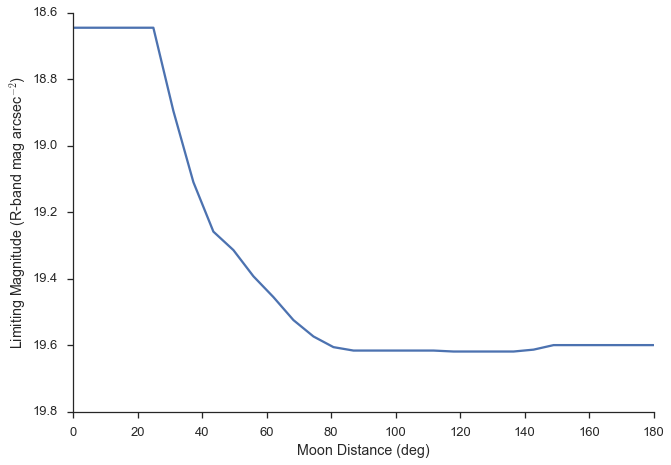

In [9]:
moon_dists = np.linspace(0,180,30)
dft = test_conditions(moonillf=0.8,moon_dist=moon_dists)
skies = Sky.predict(dft)
plt.plot(moon_dists,skies)
plt.gca().invert_yaxis()
plt.xlabel('Moon Distance (deg)')
plt.ylabel('Limiting Magnitude (R-band mag arcsec$^{-2}$)')
sns.despine()

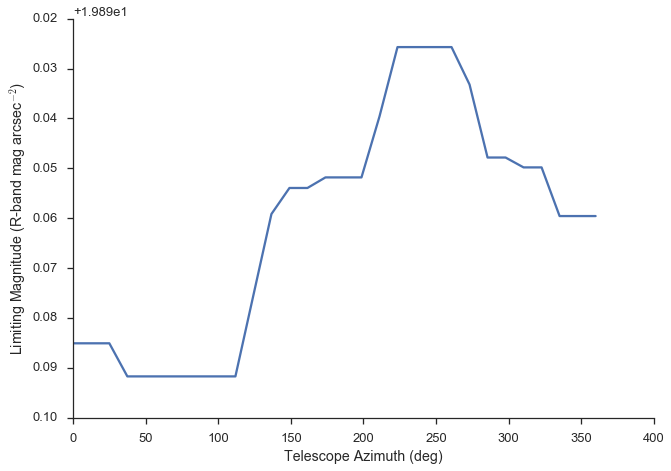

In [10]:
azimuths = np.linspace(0,360,30)
dft = test_conditions(azimuth=azimuths)
skies = Sky.predict(dft)
plt.plot(azimuths,skies)
plt.gca().invert_yaxis()
plt.xlabel('Telescope Azimuth (deg)')
plt.ylabel('Limiting Magnitude (R-band mag arcsec$^{-2}$)')
sns.despine()

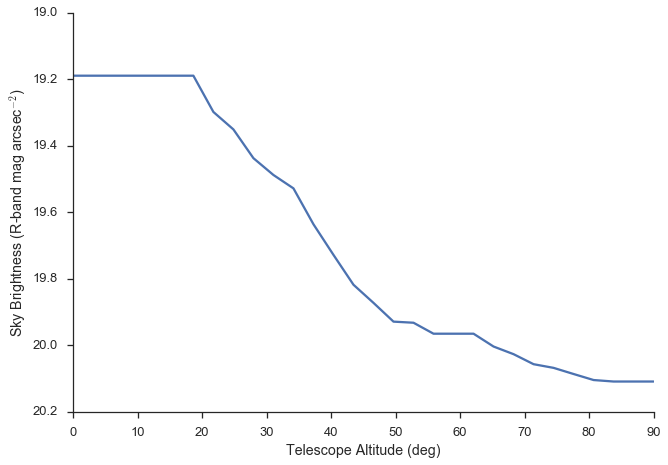

In [11]:
altitudes = np.linspace(0,90,30)
dft = test_conditions(altitude=altitudes)
skies = Sky.predict(dft)
plt.plot(altitudes,skies)
plt.gca().invert_yaxis()
plt.xlabel('Telescope Altitude (deg)')
plt.ylabel('Sky Brightness (R-band mag arcsec$^{-2}$)')
sns.despine()

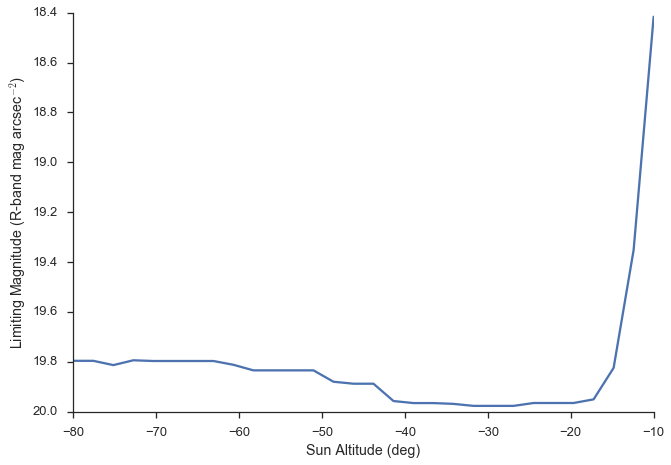

In [12]:
sunalts = np.linspace(-10,-80,30)
dft = test_conditions(sunalt=sunalts)
skies = Sky.predict(dft)
plt.plot(sunalts,skies)
plt.gca().invert_yaxis()
plt.xlabel('Sun Altitude (deg)')
plt.ylabel('Limiting Magnitude (R-band mag arcsec$^{-2}$)')
sns.despine()